# LSPIV - Part 1: Image preparation
*GH Gerritsen*
___

This notebook shows the application of different image preparation steps on an example video using the `OpenCV` library [1]. These image preparation combined in the file `imageprep.py` steps are:

- *Lens distortion correction*: `ip.lens_corr()` to correct for distortion due to the lens characteristics.
- *Orthorectification*: `ip.orthorect_param()` and `ip.orthorect_trans()` to correct distortions caused by the perspective (when filming with an incline).
- *Grey scaling, contrast- and gamma correction*: `ip.color_corr()` to enhance the visibility of the seeds.

For this process, several parameters are needed: for *lens distortion correction* the camera characteristics; for *orthorectification* the paramteres are estimated using the locations of the ground control points (GCPs); and for *Grey scaling, contrast- and gamma correction* the alpha, beta, and gamma parameters have to be chosen.

This notebook uses the video `example_video.mp4` for the image preparation process, and saves the individual frames in the folder `frames`, which will be created if non-existent.

In [1]:
%matplotlib notebook

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import imageprep as ip

In [2]:
dir_video = 'example_video.mp4'
dir_saves = 'frames'

In [3]:
if not os.path.exists(dir_saves):
    os.mkdir(dir_saves)

## Orthorectification parameter estimation

The orthorectification parameters (transformation matrix and the corresponding imagery size) are determined using the locations of the GCPs. These locations are set in an imagery coordinate system (pixels): `df_from`, and a local coordinate system (metres or lon-lat coordinates). These GCP locations are stored in a `pd.DataFrames` containing `x` and `y` coordinates.

To estimate the locations in the imagery coordinate system, the imagery has to be corrected for lens distortion. In the figure shown below, the estimated locations if the GCPs in the imagery are presented. Thereafter, using the function `ip.orthorect_param()` the orthorectification parameters are estimated. As, `df_from` is in metres, `lonlat` is set to False.

In [4]:
# GCP locations in the imagery (pixels)
data_from = {'x': [992, 1545, 1773,  943],
             'y': [366,  403,  773,  724]}
df_from = pd.DataFrame(data_from)

# GCP locations in local coordinate system (metres)
data_to = {'x': [ 0.25, 4.25, 4.50, 0.00],
           'y': [ 0.30, 0.20, 3.50, 3.50]}
df_to = pd.DataFrame(data_to)

<IPython.core.display.Javascript object>


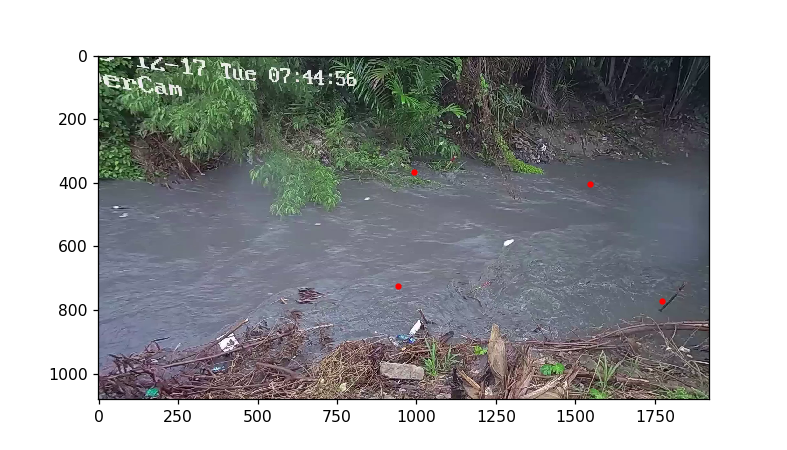

In [5]:
# to locate the GCPts in the imagery:
# import the video and correct the first frame for lens distortion

cap = cv2.VideoCapture(dir_video)
if cap.isOpened():
    ret, img = cap.read()
    corr_img = ip.lens_corr(img, k1=-10.0e-6, c=2, f=8.0)
cap.release()

# show the corrected image and the locations of the GCPs
fig = plt.figure(figsize=(7,4))
plt.imshow(corr_img[:,:,::-1])
plt.plot(df_from.x, df_from.y ,'r.')

___

In [6]:
# determine orthorectification parameters
M, C, __ = ip.orthorect_param(corr_img, df_from, df_to, PPM=100, lonlat=False)

# set the size of the orthorectified image
cols = int(np.ceil(max(C[:, 0])))
rows = int(np.ceil(max(C[:, 1])))

## Image preparation

Now the orthorectification matrix is defined and the size of the resulting image is known, the whole video can be processed. The following loop seperates the video into seperate images and applies for each image the different image preparation steps. The individual images are cropped and saved at the aforementioned location.

In [7]:
# counter to use as name for the individual images
n = 0

# import video and read each individual image (frame)
cap = cv2.VideoCapture(dir_video)
while cap.isOpened():
    ret, img = cap.read()
    if ret:

        # apply lens distortion correction
        img_dist = ip.lens_corr(img, k1=-10.0e-6, c=2, f=8.0)

        # apply orthorectification
        img_orth = ip.orthorect_trans(img_dist, M, C)

        # apply gray scaling, contrast- and gamma correction
        img_grey = ip.color_corr(img_orth, alpha=None, beta=None, gamma=0.4)

        # crop the image to a more reasonable size excluding the outer boundaries
        # the image could be cropped to the extend of the area of interest
        img_out = img_grey[max(0, rows-1000):, :min(2000, cols)]

        # save the image with name 'n'
        framename = os.path.join(dir_saves,
                                 'frame_'+str(format(n).zfill(6))+'.jpg')
        cv2.imwrite(framename, img_out)
        n += 1

    else:
        break

cap.release()

___
[1] OpenPIV documentation and tutorials - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html 
___
**Possible additions:**

- Orthorectification based on 6 or more GCPs using e.g. a Pinhole model as explained in Jodeau et al. (2008) *Application and evaluation of LS-PIV technique for the monitoring of river surface velocities in high flow conditions*.
- Automated contrast- and gamma correction: https://answers.opencv.org/question/75510/how-to-make-auto-adjustmentsbrightness-and-contrast-for-image-android-opencv-image-correction/?sort=votes